# Lab 7 - Spatially Constrained Clustering, 
# Hierarchical Methods

This notebook introduces methods to impose *hard* spatial constraints in a clustering procedure. We consider three methods that use a hierarchical clustering logic: spatially constrained hierarchical clustering (SCHC), SKATER (Spatial Kluster Analysis by Tree Edge Removal) and REDCAP (REgionalization with Dynamically Constrained Agglomerative clustering and Partitioning), covered in Chapter 10 of Anselin (2024).

There currently is little support for spatially constrained clustering in `sklearn`. Only the SCHC method can be implemented by means of a so-called *structured* approach. This allows for the specification of a `connectivity` argument to constrain the solution. All other methods are implemented with `pygeoda`.

The material is part of the Spatial Cluster Analysis course taught at the University of Chicago in the Winter Quarter of 2025.

Prepared by: Luc Anselin (anselin@uchicago.edu) and Pedro Amaral (pedroamaral@uchicago.edu)

## Preliminaries
The empirical illustration is based on the material in Chapter 10 of the Spatial Cluster book.

### Required packages

The conda enviroment used for this exercise was created from a yml file with the same specification as in the previous notebooks:

In addition to the usual `numpy` and `geopandas`, we import `sklearn.cluster` to implement `AgglomerativeClustering` and `StandardScaler` from `sklearn.preprocessing` for the usual standardization. The weights are created using `libpysal.weights`. All four clustering methods are implemented in `pygeoda`.

We also import `time` to compare the relative performance of `pygeoda` and `sklearn.cluster` for the SCHC case.

As before, we import several functions from the `spatial_cluster_helper` package:

- `cluster_stats`
- `cluster_fit`
- `cluster_center`
- `cluster_map`

In [1]:
import geopandas as gpd
import numpy as np
import time

from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler

from libpysal.weights import Queen

from spatial_cluster_helper import cluster_stats, cluster_fit, cluster_center, cluster_map

import pygeoda

### Load data

For this exercise, we will use the same data set as before on Zika and Microcephaly infections and socio-economic profiles for 2013-2016 in municipalities in the State of Ceará, Brazil. This is also a GeoDa sample data set. Detailed source and information available at https://geodacenter.github.io/data-and-lab/Ceara-Zika/

The following files will be used:
- **ceara.shp,shx,dbf,prj**: shape file (four files) for 184 municipalities

We follow the usual practice of setting a path (if needed), reading the data from the shape file and a quick check of its contents (`head`).

In [ ]:
# Setting working folder:
#path = "/your/path/to/data/"
path = ""

# Load the Ceará data:
dfs = gpd.read_file(path+"ceara/ceara.shp")
print(dfs.shape)
dfs.head(3)

(184, 36)


,code7,mun_name,state_init,area_km2,state_code,micro_code,micro_name,inc_mic_4q,inc_zik_3q,inc_zik_2q,...,gdp,pop,gdpcap,popdens,zik_1q,ziq_2q,ziq_3q,zika_d,mic_d,geometry
0,2300101.0,Abaiara,CE,180.833,23,23019,19Âª RegiÃ£o Brejo Santo,0.000000,0.0,0.00,...,35974.0,10496.0,3.427,58.043,0.0,0.0,0.0,0.0,0.0,"POLYGON ((5433729.65 9186242.97, 5433688.546 9..."
1,2300150.0,Acarape,CE,130.002,23,23003,3Âª RegiÃ£o MaracanaÃº,6.380399,0.0,0.00,...,68314.0,15338.0,4.454,117.983,0.0,0.0,0.0,0.0,1.0,"POLYGON ((5476916.288 9533405.667, 5476798.561..."
2,2300200.0,AcaraÃº,CE,842.471,23,23012,12Âª RegiÃ£o AcaraÃº,0.000000,0.0,1.63,...,309490.0,57551.0,5.378,68.312,0.0,1.0,0.0,1.0,0.0,"POLYGON ((5294389.783 9689469.144, 5294494.499..."


In [3]:
# the full set of variables
print(list(dfs.columns))

['code7', 'mun_name', 'state_init', 'area_km2', 'state_code', 'micro_code', 'micro_name', 'inc_mic_4q', 'inc_zik_3q', 'inc_zik_2q', 'inc_zik_1q', 'prim_care', 'ln_gdp', 'ln_pop', 'mobility', 'environ', 'housing', 'sanitation', 'infra', 'acu_zik_1q', 'acu_zik_2q', 'acu_zik_3q', 'pop_zikv', 'acu_mic_4q', 'pop_micro', 'lngdpcap', 'gdp', 'pop', 'gdpcap', 'popdens', 'zik_1q', 'ziq_2q', 'ziq_3q', 'zika_d', 'mic_d', 'geometry']


#### Selecting variables and checking their correlation

As in Chapter 10 of Anselin (2024) (https://lanselin.github.io/introbook_vol2/CHspatialhierarchical.html), we select the following variables from the Ceará sample data set.

List of variables:
| Column Name | Description                                      |
|-------------|--------------------------------------------------|
| mobility    | Mobility index                                  |
| environ     | Environment index                               |
| housing     | Housing index                                  |
| sanitation  | Sanitation index                               |
| infra       | Infrastructure index                           |
| gdpcap      | GDP per capita                                  | 



We specify the variables in a list for later use.

In [4]:
varlist = ['mobility', 'environ', 'housing', 'sanitation', 'infra', 'gdpcap']

We also use the geo data frame to create a data object that is compatible with `pygeoda` using its `open` command. In addition, we create queen contiguity weights using `queen_weights` and briefly check their characteristics.

In [5]:
ceara_g = pygeoda.open(dfs)
queen_w = pygeoda.queen_weights(ceara_g)
queen_w

Weights Meta-data:
 number of observations:                  184
           is symmetric:                 True
               sparsity:  0.02953686200378072
        # min neighbors:                    1
        # max neighbors:                   13
       # mean neighbors:    5.434782608695652
     # median neighbors:                  5.0
           has isolates:                False

Because we will be using `pygeoda` for the clustering algorithms, we need the relevant variables in a pygeoda data format. However, because we will also use `sklearn` and the various helper functions from the `pysal_cluster_helper` module, we will need a geo data frame subset as well. We extract the variables respectively as `data` (geo data frame) and `data_g` (for pygeoda) for future use.

Finally, we will also need the weights as a sparse array. To accomplish that, we create queen weights from the GeoDataFrame using `libpysal.weights`.

In [6]:
data = dfs[varlist]
data_g = ceara_g[varlist]
wq = Queen.from_dataframe(dfs)
wq.n

/var/folders/yp/7y0q23c160n3kjkbqftgdvkc0000gn/T/ipykernel_6051/902380611.py:3: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  wq = Queen.from_dataframe(dfs)


184

To ensure compatibility between the cluster statistics in `sklearn` and in `pygeoda`, we compute the scaling factor `nn` to obtain the same standardization.

In [7]:
n = data.shape[0]
nn = (n-1.0)/n

## SCHC

The first method we consider is spatially constrained hierarchical clustering. This proceeds in the same manner as hierarchical clustering, but the closest units are only merged when they are also contiguous. This requires a continuous updating of the spatial weights information.

We first consider the implementation in `pygeoda`. The specific method is `schc`. It takes the number of clusters, the spatial weights object (from `pygeoda`), the variables in `pygeoda` format, and the linkage method, here set to `"ward"`.

The result is a *dictionary* that contains various measures of fit, as well as a cluster label for each observation. In contrast to what is the case for cluster computations in scikit-learn, the labels start at 1, not at 0.

We apply this for 12 clusters for the Ceará variables and list the `keys` of the return object.

In [8]:
n_clusters = 12
t0 = time.time()
ceara_clusters1 = pygeoda.schc(n_clusters, queen_w, data_g, "ward")
t1 = time.time()
tpygeoda = t1 - t0
print(tpygeoda)
print(ceara_clusters1.keys())

0.0037848949432373047
dict_keys(['Total sum of squares', 'Within-cluster sum of squares', 'Total within-cluster sum of squares', 'Total between-cluster sum of squares', 'The ratio of between to total sum of squares', 'Clusters'])


The cluster labels are contained in the `'Clusters'` item in the dictionary. We can extract them as `cluster_labels1` for use in our helper functions. For example, `cluster_stats` will return the cardinality of each cluster.

In [9]:
cluster_labels1 = np.array(ceara_clusters1['Clusters'])
print(cluster_stats(cluster_labels1))

    Labels  Cardinality
0        1           79
1        2           48
2        3           21
3        4           17
4        5            5
5        6            4
6        7            3
7        8            2
8        9            2
9       10            1
10      11            1
11      12            1


The remaining keys contain measures of fit. We can print them in a simple loop, excluding the last item (the cluster labels).

In [10]:
for key in list(ceara_clusters1.keys())[:-1]:  # Print all results except the cluster labels
    print(f"{key}: {np.round(ceara_clusters1[key],4)}")

Total sum of squares: 1098.0
Within-cluster sum of squares: [225.7318 168.248   93.8421  46.7944  18.098   11.0881   5.5954   2.0036
  16.9901   0.       0.       0.    ]
Total within-cluster sum of squares: 588.3915
Total between-cluster sum of squares: 509.6085
The ratio of between to total sum of squares: 0.4641


Alternatively, we can also apply our `cluster_fit` helper function. The results are identical, as long as we set the `correct` argument to `True`. This ensures that the same standardization is used as in `GeoDa` (the default in scikit-learn is a variance computation without degrees of freedom correction).

In [11]:
fit = cluster_fit(data,cluster_labels1,n_clusters,correct=True,printopt=True)


Total Sum of Squares (TSS): 1098.0
Within-cluster Sum of Squares (WSS) for each cluster: [225.732 168.248  93.842  46.794  18.098  11.088   5.595   2.004  16.99
   0.      0.      0.   ]
Total Within-cluster Sum of Squares (WSS): 588.391
Between-cluster Sum of Squares (BSS): 509.609
Ratio of BSS to TSS: 0.464


Our `cluster_center` helper function will list the cluster mean and median for each variable.

In [12]:
clust_means,clust_medians = cluster_center(data, cluster_labels1)
print("Cluster Means:\n",np.round(clust_means,3))
print("Cluster Medians:\n",np.round(clust_medians,3))

Cluster Means:
          mobility  environ  housing  sanitation  infra  gdpcap
cluster                                                       
1           0.965    0.891    0.846       0.672  0.524   4.508
2           0.952    0.844    0.795       0.597  0.504   4.483
3           0.950    0.879    0.844       0.576  0.441   6.834
4           0.951    0.758    0.844       0.649  0.588   4.821
5           0.968    0.815    0.792       0.581  0.438   4.246
6           0.833    0.766    0.818       0.792  0.574  12.600
7           0.992    0.942    0.824       0.870  0.625   6.823
8           0.859    0.687    0.722       0.584  0.417   4.644
9           0.974    0.657    0.781       0.823  0.693   5.432
10          0.951    0.824    0.771       0.573  0.443  25.464
11          0.936    0.789    0.794       0.545  0.425  27.625
12          0.957    0.966    0.857       0.593  0.357  40.018
Cluster Medians:
          mobility  environ  housing  sanitation  infra  gdpcap
cluster              

Finally, as before, we can use `cluster_map` to create a unique values map for the clusters.

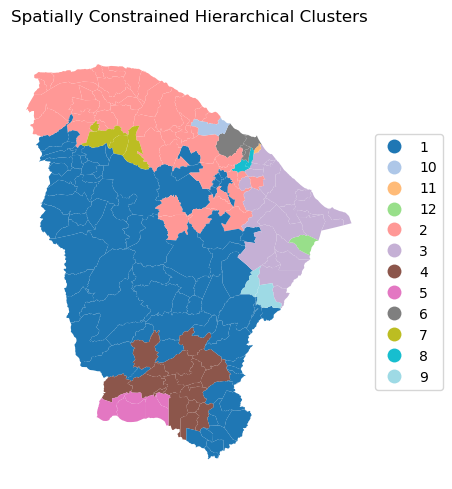

In [13]:
cluster_map(dfs, cluster_labels1, figsize=(5,5), title="Spatially Constrained Hierarchical Clusters", cmap='tab20')

### SCHC with Scikit-Learn

The `AgglomerativeClustering` functionality in `sklearn.cluster` includes an option for a so-called *structured* approach, which imposes prior constraints through a `connectivity` argument, which takes a sparse CSR array. This is in essence spatially constrained clustering, although it is not directly referred to as such. We can readily obtain an array in the proper sparse format by applying the `sparse` method to a `PySAL` spatial weights object. In our application, this is `wq`.

The call to `AgglomerativeClustering` is structured in the same way as shown in the respective notebook. First, `StandardScaler` is used to `fit_transform` the cluster variables, followed by a scaling for compatibility. An instance of the `AgglomerativeClustering` class is created as `agg_clust`, which has all the standard arguments with the addition of `connectivity = wq.sparse`. After the `fit` method is applied, the cluster labels (`cluster_labels1a`) are extracted as `agg_clust.labels_`. We then apply the `cluster_stats` helper function. Whereas the ordering of the cluster cardinalities is different from that provided by `pygeoda`, the values are identical.

In [14]:
n_clusters = 12
method = 'ward'
t0 = time.time()
X0 = StandardScaler().fit_transform(data)
X = X0 * nn

agg_clust = AgglomerativeClustering(n_clusters=n_clusters, connectivity = wq.sparse,
                                    linkage=method, compute_distances=True)
agg_clust.fit(X)
t1 = time.time()
tsklearn = t1 - t0
print(tsklearn)
cluster_labels1a = agg_clust.labels_
cluster_stats(cluster_labels1a)

0.008770942687988281


,Labels,Cardinality
0,0,48
1,1,21
2,2,2
3,3,17
4,4,79
5,5,3
6,6,4
7,7,1
8,8,1
9,9,2


The cluster fit properties are the same as well, as is the resulting cluster map.

In [15]:
fit = cluster_fit(data,cluster_labels1a,n_clusters,correct=True,printopt=True)


Total Sum of Squares (TSS): 1098.0
Within-cluster Sum of Squares (WSS) for each cluster: [168.248  93.842  16.99   46.794 225.732   5.595  11.088   0.      0.
   2.004  18.098   0.   ]
Total Within-cluster Sum of Squares (WSS): 588.391
Between-cluster Sum of Squares (BSS): 509.609
Ratio of BSS to TSS: 0.464


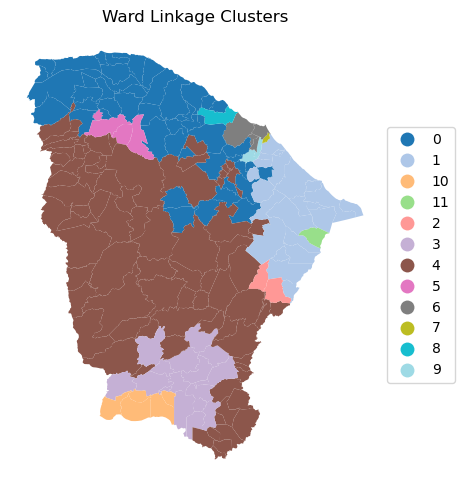

In [16]:
cluster_map(dfs, cluster_labels1a, figsize=(5,5), title="Ward Linkage Clusters", cmap='tab20')

To conclude our comparison, we compute the ratio of the time for `sklearn` to that for `pygeoda`. As our timing experiments showed, the latter is quite a bit faster. The specific times may vary slightly, but the ratio is roughly that `sklearn` is 2-3 times slower.

In [17]:
print(np.round(tsklearn/tpygeoda,4))

2.3174


## SKATER

In contrast to the agglomerative SCHC, SKATER is a divisive hierarchical approach. It is based on a reduction of the graph structure implied by the spatial weights to a minimum spanning tree, based on the inter-observation dissimilarity. The original graph is essentially a weighted form of the spatial weights matrix, where the existence of a contiguity between two observations is weighted by their dissimilarity. From the initial minimum spanning tree, the SKATER algorithm proceeds by finding optimal *cuts* in the tree, which each form a subcluster. This process continues until the desired number of clusters is found.

One downside of this approach is that observations are trapped in subclusters and cannot further be swapped.

The algorithm is invoked with the `skater` method of `pygeoda`. This again requires the number of clusters, the spatial weights and the `pygeoda` variables as arguments. The return object is again a dictionary with the same structure as before.

We use the helper functions to generate the cluster cardinality, cluster fit, cluster centers and cluster map.

For simplicity, all commands are combined in one notebook cell.

    Labels  Cardinality
0        1          107
1        2           41
2        3           15
3        4            4
4        5            4
5        6            3
6        7            3
7        8            3
8        9            1
9       10            1
10      11            1
11      12            1

Total Sum of Squares (TSS): 1098.0
Within-cluster Sum of Squares (WSS) for each cluster: [398.019 135.799  48.297  11.088   9.206   9.127   5.595   5.956   0.
   0.      0.      0.   ]
Total Within-cluster Sum of Squares (WSS): 623.089
Between-cluster Sum of Squares (BSS): 474.911
Ratio of BSS to TSS: 0.433
Cluster Means:
          mobility  environ  housing  sanitation  infra  gdpcap
cluster                                                       
1           0.962    0.861    0.840       0.656  0.531   4.475
2           0.954    0.862    0.802       0.615  0.499   4.687
3           0.944    0.890    0.829       0.549  0.415   7.315
4           0.833    0.766    0.818       0.792

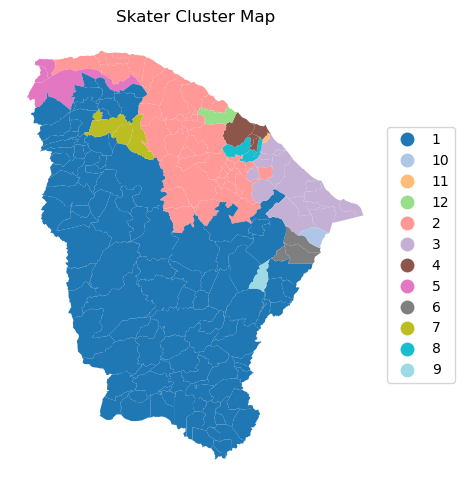

In [18]:
ceara_clusters2 = pygeoda.skater(n_clusters, queen_w, data_g)
cluster_labels2 = np.array(ceara_clusters2['Clusters'])
print(cluster_stats(cluster_labels2))
fit = cluster_fit(data,cluster_labels2,n_clusters,correct=True,printopt=True)
clust_means,clust_medians = cluster_center(data, cluster_labels2)
print("Cluster Means:\n",np.round(clust_means,3))
print("Cluster Medians:\n",np.round(clust_medians,3))
# Plot the clusters
cluster_map(dfs, cluster_labels2, figsize=(5,5), title="Skater Cluster Map", cmap='tab20')

### Additional constraints in the clustering

`GeoDa` offers the option to provide a constraint on the cluster size. This is typically expressed as a function of a spatially extensive variable, such as population in the Ceará example. This additional constraint ensures that no cluster contains less than the set limit. In practice, this is often needed when building regions to report rates on rare diseases to protect privacy. Note that the specified constraints may sometimes conflict with the desired number of clusters in the sense that there is no solution that satisfies both the number of clusters and the minimum size constraint. In that case, the largest number of possible clusters that satisfy the constraint is given as the solution.

The contraint is implemented in `pygeoda` by means of the `bound_variable` and `min_bound` arguments. Similar to the example in Chapter 10, we use population (`pop`) to set the bound at a minimum of 10% of the overall population. In all other respects, the approach remains the same. 

We again group all commands in a single notebook cell.

   Labels  Cardinality
0       1           43
1       2           40
2       3           36
3       4           32
4       5           26
5       6            7

Total Sum of Squares (TSS): 1098.0
Within-cluster Sum of Squares (WSS) for each cluster: [156.507 172.008 158.72  113.536 208.516  43.745]
Total Within-cluster Sum of Squares (WSS): 853.033
Between-cluster Sum of Squares (BSS): 244.967
Ratio of BSS to TSS: 0.223
Cluster Means:
          mobility  environ  housing  sanitation  infra  gdpcap
cluster                                                       
1           0.964    0.884    0.841       0.644  0.532   4.562
2           0.956    0.857    0.797       0.617  0.495   5.292
3           0.961    0.817    0.836       0.645  0.535   4.485
4           0.964    0.880    0.844       0.711  0.544   4.601
5           0.946    0.861    0.830       0.566  0.451   8.434
6           0.851    0.742    0.785       0.715  0.508   9.475
Cluster Medians:
          mobility  environ  housing  

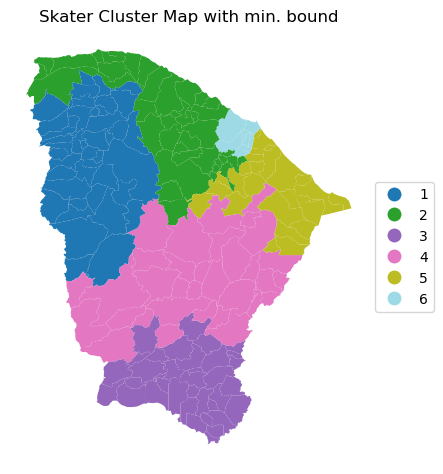

In [19]:
ceara_clusters3 = pygeoda.skater(n_clusters, queen_w, data_g, bound_variable=dfs['pop'], min_bound=dfs['pop'].sum()/10)
cluster_labels3 = np.array(ceara_clusters3['Clusters'])
print(cluster_stats(cluster_labels3))
fit = cluster_fit(data,cluster_labels3,n_clusters,correct=True,printopt=True)
clust_means,clust_medians = cluster_center(data, cluster_labels3)
print("Cluster Means:\n",np.round(clust_means,3))
print("Cluster Medians:\n",np.round(clust_medians,3))
cluster_map(dfs, cluster_labels3, figsize=(5,5), title="Skater Cluster Map with min. bound", cmap='tab20')

Note how even though we set the number of clusters to 12, only a solution with six clusters could be obtained such that the minimum population requirement is satisfied. Also, the overall fit of the solution is seriously deteriorated, to a BSS/TSS ratio of 0.223, compared to the original 0.433.

## REDCAP

The final hierarchical method is REDCAP, which is a combination of an agglomerative approach with the use of a minimum spanning tree. Several variants of the method are available, combining a type of hierarchical clustering linkage with the way the neighbor structure is updated (for full details, see the Cluster Book and the `pygeoda` docs). Of all the combinations, five are supported by `pygeoda`:
- `firstorder-singlelinkage`
- `fullorder-singlelinkage`
- `fullorder-averagelinkage`
- `fullorder-completelinkage`
- `fullorder-wardlinkage`

Here, we will illustrate the `fullorder-wardlinkage` method, which is passed as the `method` argument to the `redcap` function. Everything else operates as before. Again, we combine all commands in a single notebook cell.

    Labels  Cardinality
0        1           77
1        2           52
2        3           21
3        4           16
4        5            5
5        6            3
6        7            3
7        8            2
8        9            2
9       10            1
10      11            1
11      12            1

Total Sum of Squares (TSS): 1098.0
Within-cluster Sum of Squares (WSS) for each cluster: [214.614 173.74   63.005  66.063  38.299   5.595   9.602   2.004  16.99
   0.      0.      0.   ]
Total Within-cluster Sum of Squares (WSS): 589.912
Between-cluster Sum of Squares (BSS): 508.088
Ratio of BSS to TSS: 0.463
Cluster Means:
          mobility  environ  housing  sanitation  infra  gdpcap
cluster                                                       
1           0.966    0.894    0.847       0.675  0.526   4.527
2           0.951    0.842    0.793       0.583  0.495   4.974
3           0.952    0.762    0.839       0.626  0.571   4.646
4           0.950    0.887    0.858       0.6

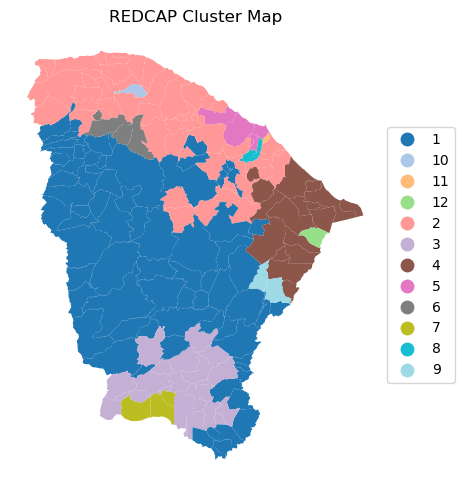

In [20]:
ceara_clusters4 = pygeoda.redcap(n_clusters, queen_w, data_g, method='fullorder-wardlinkage')
cluster_labels4 = np.array(ceara_clusters4['Clusters'])
print(cluster_stats(cluster_labels4))
fit = cluster_fit(data,cluster_labels4,n_clusters,correct=True,printopt=True)
clust_means,clust_medians = cluster_center(data, cluster_labels4)
print("Cluster Means:\n",np.round(clust_means,3))
print("Cluster Medians:\n",np.round(clust_medians,3))
cluster_map(dfs, cluster_labels4, figsize=(5,5), title="REDCAP Cluster Map", cmap='tab20')